# Brain Tumor Detection

In this notebook I will include different types of solutions for brain tumor detection. The dataset is collected from [here](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection). The solutions are collected from different notebooks. As a learning process, I am collecting different solutions from different notebooks, trying to improve performace of the model and comparing the performance of the different model on this dataset.

We will use 3 models on this notebook, which are ResNet50v2, VGG19 and InceptionV3. So the contents of the notebook will be as follows,

* Importing libraries
* Loading Images and creating utility function for data augmentation
* Image demostration
* CNN models
    1. ResNet50V2
        * Training without data augmentation
        * Further tune the model with data augmentation   
    2. VGG19
        * Training without data augmentation
        * Further tune the model with data augmentation 
    3. InceptionV3
        * Training without data augmentation
        * Further tune the model with data augmentation 


Let's get started!


**NOTE: I have added a new section, which includes the testing images(test_ds). This is to check the overfitting of our models. I will try new changes to improve the performance in future updates.**

# Importing the libraries


* Numpy and pandas for data analysis
* plotlib and seaborn for data  exploration
* sklearn metrics for measuring the performance of the model
* tensorflow and keras for building our models

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model
#tf.keras.backend.clear_session()
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

# Loading Images and creating utility function for data augmentation


In this section we will load our data(images with labels) from our dataset. The initial size(244*244) will be used for ResNet50v2, we will change the size as required for other models.

We will create two utility function for generating our data to be trained. One is image_gen, which will create train_ds and val_ds without data augmention which will be used for training the model without data augmentation. The other one is augmented_data, which will apply data_augmentation and return augmented data for train_ds which will be used to futher tune our models.

In [2]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST TRAIN/YES TRAIN/NO TEST/YES TEST/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
.
├── TEST
│   ├── NO
│   └── YES
└── TRAIN
    ├── NO
    └── YES

6 directories


In [3]:
IMG_PATH = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    print(os.listdir(IMG_PATH))
    if not CLASS.startswith('.') and CLASS != 'brain_tumor_dataset':
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)

['no', 'yes', 'brain_tumor_dataset']
98
['no', 'yes', 'brain_tumor_dataset']
155
['no', 'yes', 'brain_tumor_dataset']


In [4]:
dataset_dir = "/kaggle/working/TRAIN/"
test_dir = "/kaggle/working/TEST/"

In [5]:
data = keras.utils.image_dataset_from_directory('/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset')

Found 253 files belonging to 2 classes.


In [6]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [7]:
def image_gen(height, width, batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.2,
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    val_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )
    
    test_gen = ImageDataGenerator(
        rescale=1./255.
    )
    
    test_ds = test_gen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )

    return train_ds, val_ds, test_ds

    

def augmented_data(height, width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )
    
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
    )
    
    return train_ds

train_ds, val_ds, test_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels, test_ds.labels])

# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
{'No brain tumor cases': 98, 'Brain tumor cases': 155}


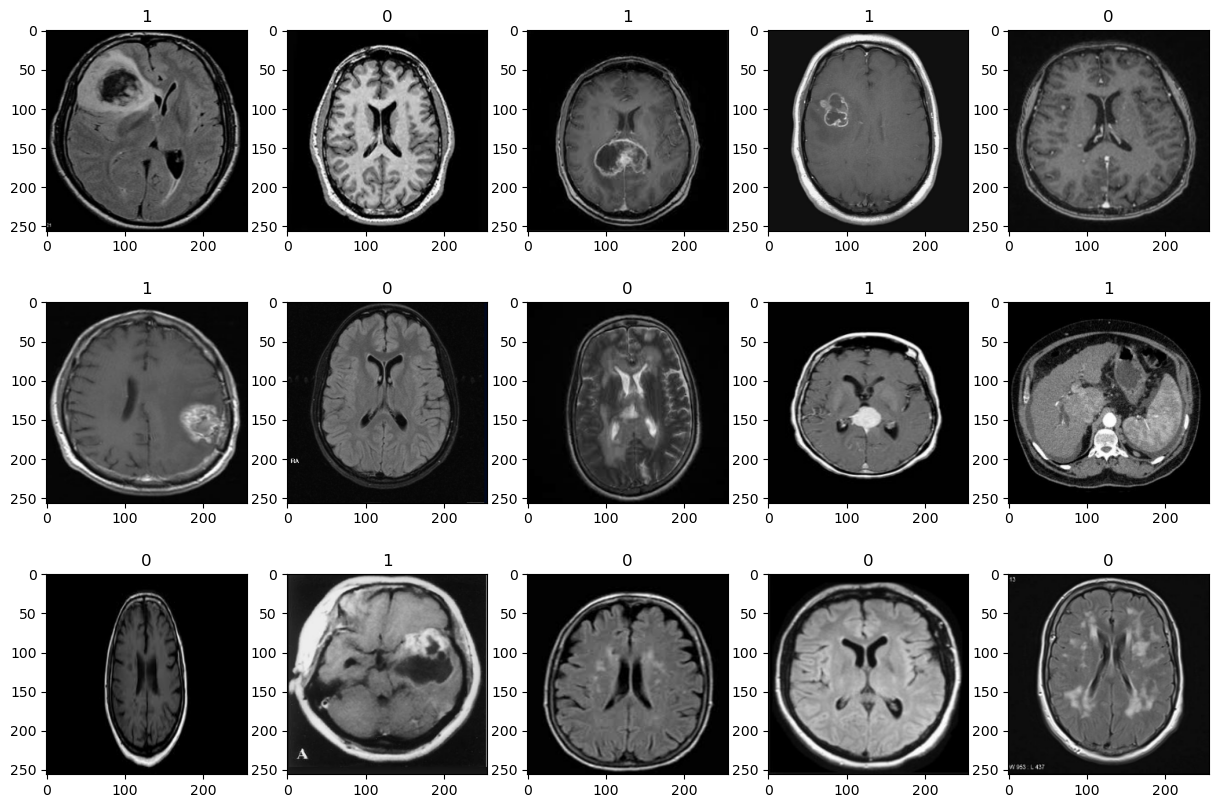

In [8]:
batch = data.as_numpy_iterator().next()
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
data = data.map(lambda x,y: (x/255, y))
batch = data.as_numpy_iterator().next()

In [10]:
print("Minimum value of the scaled data:", batch[0].min())
print("Maximum value of the scaled data:", batch[0].max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [11]:

train_size = int(len(data)*0.6)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.2)+1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Image demostration

Demostrating some of the training data.

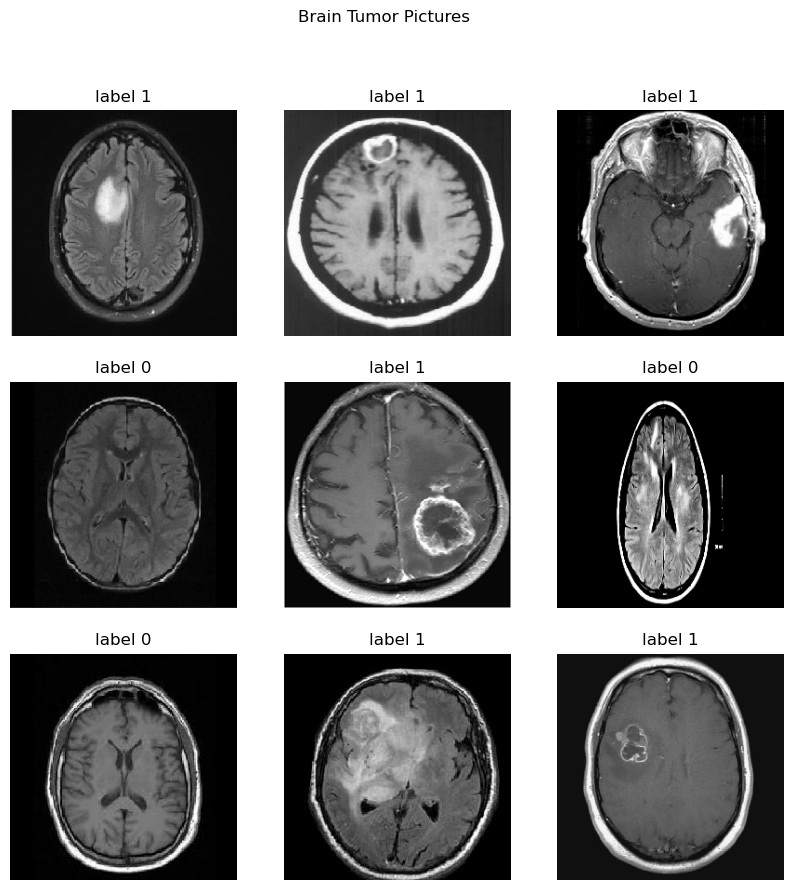

In [12]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

In [13]:
batch = data.as_numpy_iterator().next()

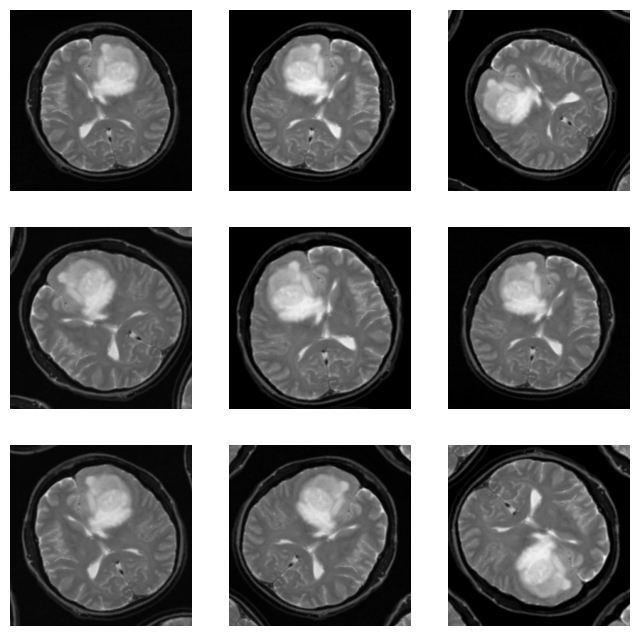

In [14]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(256,256,3)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomRotation(0.2)
])

image = batch[0]


plt.figure(figsize=(8, 8))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# 1.CNN Models

In [15]:
model = Sequential([
    data_augmentation,
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
4/4 [==============================] - 16s 455ms/step - loss: 0.6770 - accuracy: 0.5312 - val_loss: 0.6592 - val_accuracy: 0.5312
Epoch 2/15
4/4 [==============================] - 2s 392ms/step - loss: 0.6087 - accuracy: 0.6562 - val_loss: 0.6385 - val_accuracy: 0.6562
Epoch 3/15
4/4 [==============================] - 2s 383ms/step - loss: 0.5751 - accuracy: 0.7500 - val_loss: 0.5390 - val_accuracy: 0.7188
Epoch 4/15
4/4 [==============================] - 2s 369ms/step - loss: 0.5916 - accuracy: 0.7578 - val_loss: 0.5050 - val_accuracy: 0.7812
Epoch 5/15
4/4 [==============================] - 2s 395ms/step - loss: 0.6066 - accuracy: 0.6953 - val_loss: 0.6030 - val_accuracy: 0.6875
Epoch 6/15
4/4 [==============================] - 2s 384ms/step - loss: 0.5668 - accuracy: 0.7188 - val_loss: 0.4358 - val_accuracy: 0.8125
Epoch 7/15
4/4 [==============================] - 2s 417ms/step - loss: 0.5798 - accuracy: 0.7266 - val_loss: 0.4636 - val_accuracy: 0.8281
Epoch 8/15
4/4 [===

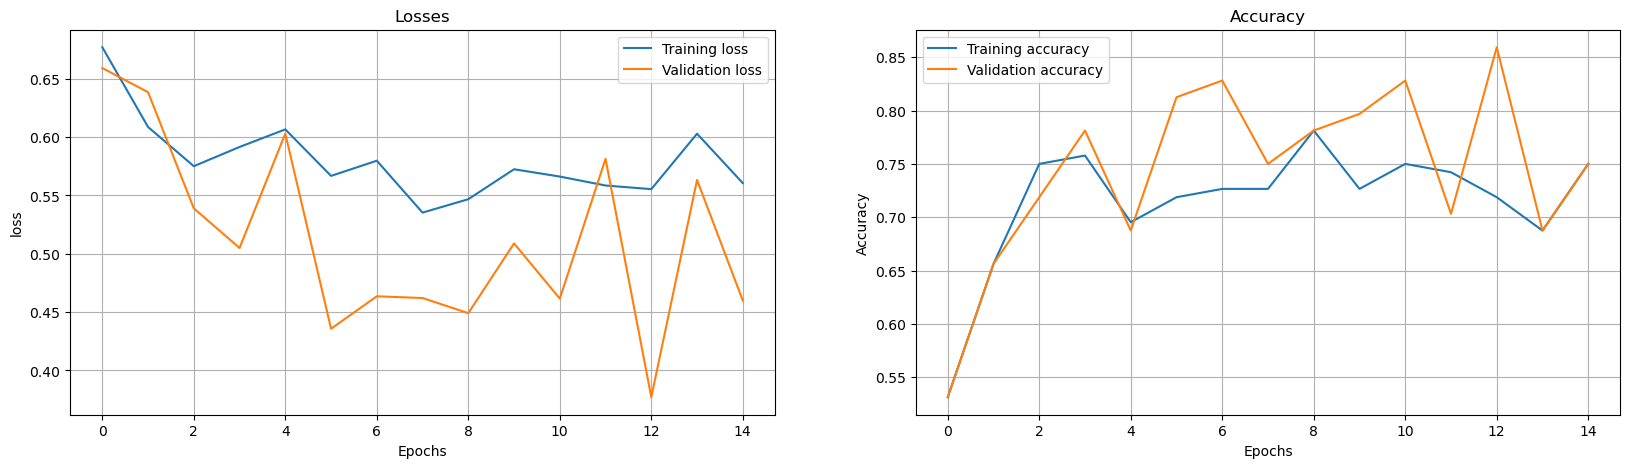

In [16]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# Tumor Detection Manually

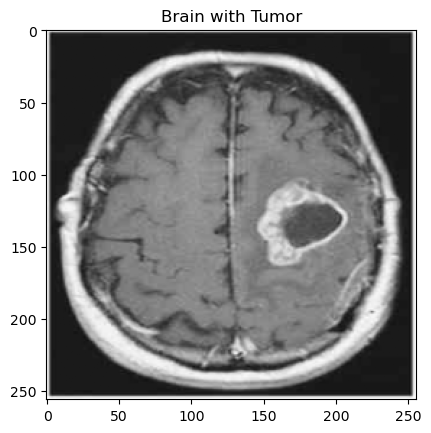

In [21]:
batch = test.as_numpy_iterator().next()
img, label = batch[0][15], batch[1][15]
plt.imshow(img)
if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()

In [22]:
y_hat = model.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 21ms/step


In [23]:
if y_hat < 0.5:
    print("No tumor detected")
else:
    print("Tumor detected")

Tumor detected


# 2.LSTM

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an LSTM-based model for image classification
model = keras.Sequential([
    tf.keras.layers.Input(shape=( 244, 244, 3)),  # Input layer for sequences of images
    tf.keras.layers.TimeDistributed(keras.layers.Flatten()),  # Flatten each image in the sequence
    tf.keras.layers.LSTM(128, return_sequences=True),  # LSTM layer for sequential processing
    tf.keras.layers.Flatten(),  # Flatten the output of the LSTM
    keras.layers.Dense(128, activation='relu'),  # Hidden layer
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load and preprocess the image data (as you've previously done)

history = model.fit(train_ds, validation_data=val_ds, epochs=30)


Epoch 1/30
7/7 [==============================] - 5s 276ms/step - loss: 3.7170 - accuracy: 0.5333 - val_loss: 6.7366 - val_accuracy: 0.6250
Epoch 2/30
7/7 [==============================] - 1s 175ms/step - loss: 2.4932 - accuracy: 0.5897 - val_loss: 0.8309 - val_accuracy: 0.3958
Epoch 3/30
7/7 [==============================] - 1s 141ms/step - loss: 0.7461 - accuracy: 0.6410 - val_loss: 0.5210 - val_accuracy: 0.7708
Epoch 4/30
7/7 [==============================] - 1s 155ms/step - loss: 0.6251 - accuracy: 0.7179 - val_loss: 0.5288 - val_accuracy: 0.7917
Epoch 5/30
7/7 [==============================] - 1s 137ms/step - loss: 0.5185 - accuracy: 0.7385 - val_loss: 0.4726 - val_accuracy: 0.8125
Epoch 6/30
7/7 [==============================] - 1s 135ms/step - loss: 0.4414 - accuracy: 0.7949 - val_loss: 0.5024 - val_accuracy: 0.7917
Epoch 7/30
7/7 [==============================] - 1s 160ms/step - loss: 0.4184 - accuracy: 0.8359 - val_loss: 0.4720 - val_accuracy: 0.8125
Epoch 8/30
7/7 [====

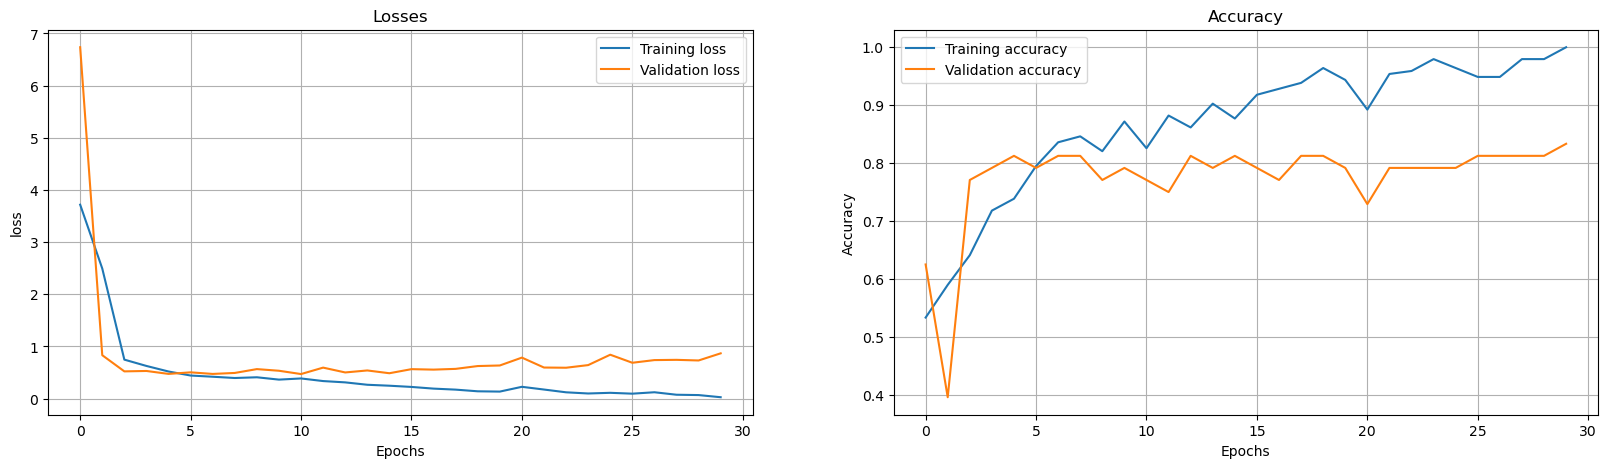

In [25]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# 3. CNN + LSTM

In [26]:
# Initialize the CNN [data_augmentation]
cnn = tf.keras.models.Sequential()

# 1st layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[244, 244, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))  # Pooling

# 2nd layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())  # Flattening

# Add LSTM layer
cnn.add(tf.keras.layers.Reshape((1, cnn.output_shape[-1])))  # Reshape the input for LSTM
cnn.add(tf.keras.layers.LSTM(units=64, activation='relu'))

# Fully connected layer
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Output layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 =cnn.fit(train_ds, validation_data = val_ds, epochs = 30)
history2

Epoch 1/30
7/7 [==============================] - 4s 182ms/step - loss: 0.9146 - accuracy: 0.5179 - val_loss: 0.5967 - val_accuracy: 0.6250
Epoch 2/30
7/7 [==============================] - 1s 129ms/step - loss: 0.5546 - accuracy: 0.6872 - val_loss: 0.4748 - val_accuracy: 0.7917
Epoch 3/30
7/7 [==============================] - 1s 132ms/step - loss: 0.4419 - accuracy: 0.8256 - val_loss: 0.5011 - val_accuracy: 0.7917
Epoch 4/30
7/7 [==============================] - 1s 125ms/step - loss: 0.3671 - accuracy: 0.8513 - val_loss: 0.4490 - val_accuracy: 0.7917
Epoch 5/30
7/7 [==============================] - 1s 125ms/step - loss: 0.2751 - accuracy: 0.8923 - val_loss: 0.4500 - val_accuracy: 0.8125
Epoch 6/30
7/7 [==============================] - 1s 128ms/step - loss: 0.1866 - accuracy: 0.9333 - val_loss: 0.8122 - val_accuracy: 0.7500
Epoch 7/30
7/7 [==============================] - 1s 119ms/step - loss: 0.1758 - accuracy: 0.9333 - val_loss: 0.4481 - val_accuracy: 0.8542
Epoch 8/30
7/7 [====

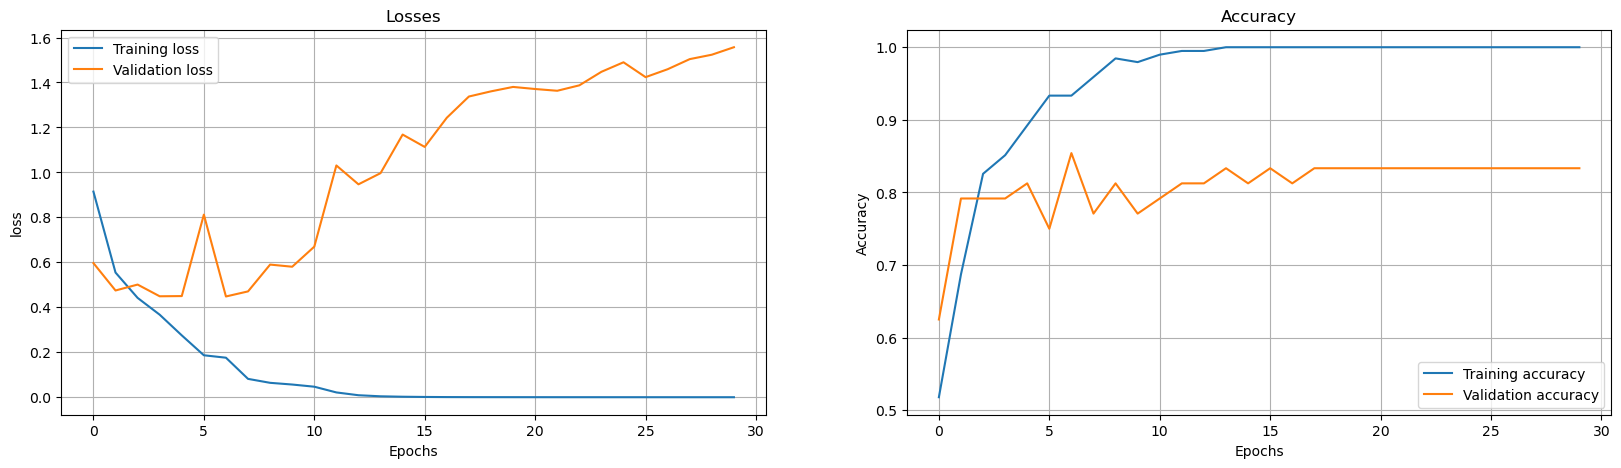

In [27]:
his_data = pd.DataFrame(history2.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [28]:
train_result = cnn.evaluate(train_ds)
val_result = cnn.evaluate(val_ds)
test_result = cnn.evaluate(test_ds)

model1_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model1_result

1/1 [==============================] - 0s 138ms/step - loss: 4.6839 - accuracy: 0.4000


,Train,Validation,Testing
Loss,0.000027,1.556849,4.683893
Accuracy,1.000000,0.833333,0.400000


# 4. ResNet50V2

We will use ResNet50V2 pre-trained model from keras. You can read more details about it from [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/ResNet50V2). We will use the pre-trained model as base model and will build a final segement with a GlobalAveragePooling2D layer, Flatten layer, 2 Dense layer and a Dropout layer. We will use softmax activation for our output layer.

**Training without data augmentation**

In [29]:
from keras.applications import ResNet50V2
tf.keras.backend.clear_session()

base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model, 
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model1.compile(optimizer=Adam(), 
               loss="sparse_categorical_crossentropy", 
               metrics=['accuracy'])

model1.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 51

In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.6872
Epoch 1: accuracy improved from -inf to 0.68718, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 7s 502ms/step - loss: 0.6302 - accuracy: 0.6872 - val_loss: 0.2779 - val_accuracy: 0.8542
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.8615
Epoch 2: accuracy improved from 0.68718 to 0.86154, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 2s 267ms/step - loss: 0.3617 - accuracy: 0.8615 - val_loss: 0.1289 - val_accuracy: 0.9583
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9026
Epoch 3: accuracy improved from 0.86154 to 0.90256, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 2s 255ms/step - loss: 0.2083 - accuracy: 0.9026 - val_loss: 0.1115 - val_accuracy: 0.9583
Epoch 4/30
7/7 [==============================] - ETA: 0s - l

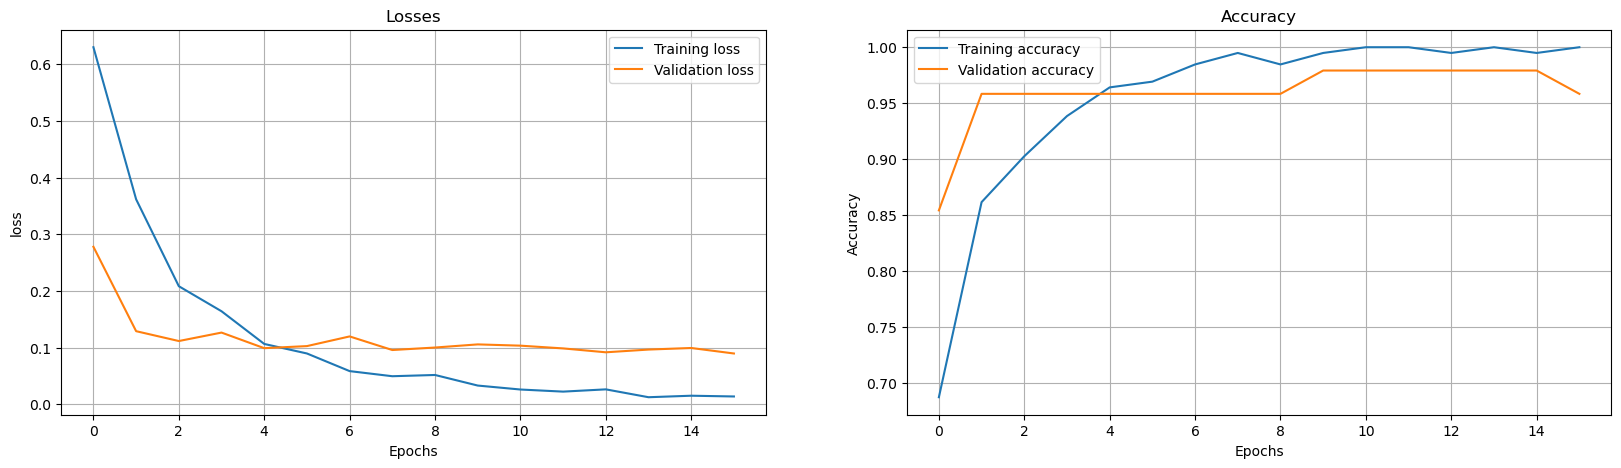

In [31]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# 5. ResNet50 + LSTM

In [32]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming you have image_gen function
#train_ds, val_ds, _ = image_gen(244, 244)

sequence_length = 10  # Adjust this based on your sequence length
input_shape = (sequence_length, 244, 244, 3)

base_model = ResNet50V2(input_shape=(244, 244, 3), include_top=False)
base_model.trainable = False

model = Sequential([
    TimeDistributed(base_model, input_shape=input_shape),
    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Flatten()),
    TimeDistributed(Dense(256, activation="relu", kernel_initializer='he_normal')),
    LSTM(units=256, activation="relu", kernel_initializer='he_normal', return_sequences=False),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(), 
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_lstm_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint, early]

history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)


Epoch 1/30


ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 233, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "time_distributed" is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: (None, None, None, None)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, None, None, None), dtype=float32)
      • training=True
      • mask=None


# MobileNet

In [33]:
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
import tensorflow as tf

# Clear Keras session
tf.keras.backend.clear_session()

# Load MobileNetV2 as the base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

# Build the new model using MobileNetV2 as the base
model1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Compile the model
model1.compile(optimizer=Adam(),
               loss="sparse_categorical_crossentropy",
               metrics=['accuracy'])

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/mobilenetv2_best.h5',
                                                monitor='accuracy', verbose=1,
                                                mode='max', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint, early]

# Train the model
history = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 1.3027 - accuracy: 0.5436
Epoch 1: accuracy improved from -inf to 0.54359, saving model to model/mobilenetv2_best.h5
7/7 [==============================] - 5s 385ms/step - loss: 1.3027 - accuracy: 0.5436 - val_loss: 1.0878 - val_accuracy: 0.4375
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.7128
Epoch 2: accuracy improved from 0.54359 to 0.71282, saving model to model/mobilenetv2_best.h5
7/7 [==============================] - 1s 192ms/step - loss: 0.5579 - accuracy: 0.7128 - val_loss: 0.6072 - val_accuracy: 0.6458
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8256
Epoch 3: accuracy improved from 0.71282 to 0.82564, saving model to model/mobilenetv2_best.h5
7/7 [==============================] - 1s 196ms/step - loss: 0.3906 - accuracy: 0.8256 - val_loss: 0.3094 - val_accuracy: 0.

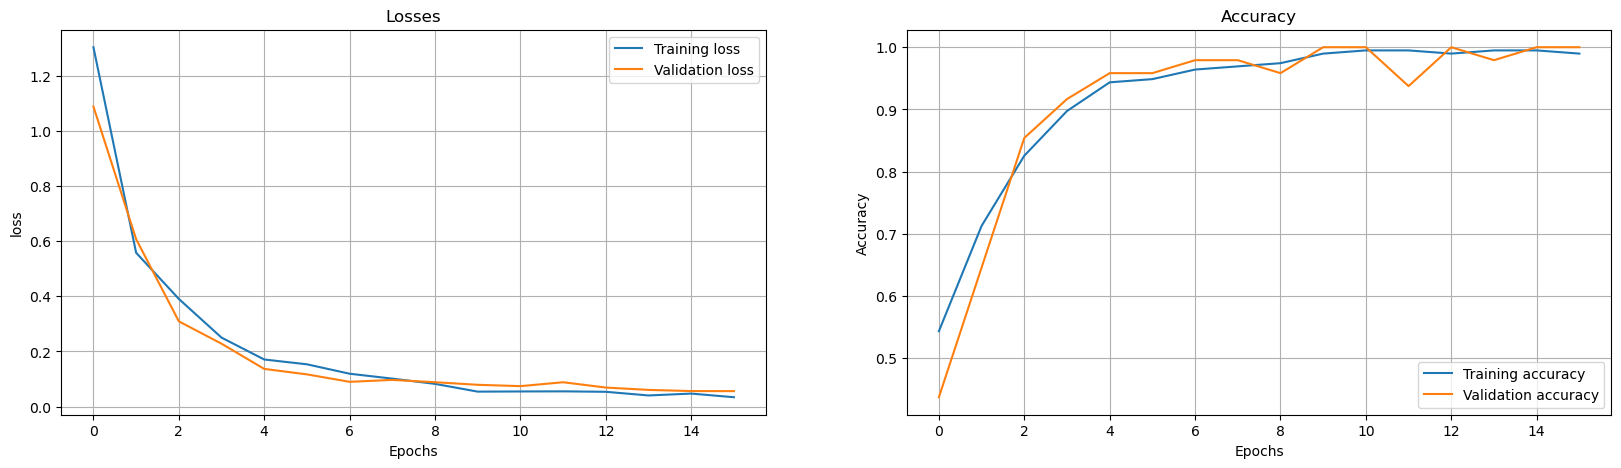

In [34]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [35]:
train_result = model1.evaluate(train_ds)
val_result = model1.evaluate(val_ds)
test_result = model1.evaluate(test_ds)

model1_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model1_result

1/1 [==============================] - 0s 196ms/step - loss: 0.7792 - accuracy: 0.7000


,Train,Validation,Testing
Loss,0.039428,0.07443,0.779211
Accuracy,0.994872,1.00000,0.700000


# ResNet + MobileNet

In [38]:
from keras.applications import ResNet50V2, MobileNetV2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input
from keras.optimizers import Adam
import tensorflow as tf

# Clear Keras session
tf.keras.backend.clear_session()

# Load ResNet50V2 as the first base model
resnet_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False)
resnet_model.trainable = False

# Load MobileNetV2 as the second base model
mobilenet_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobilenet_model.trainable = False

# Define input layer
input_layer = Input(shape=(224, 224, 3))

# Obtain outputs from both models
resnet_output = resnet_model(input_layer)
mobilenet_output = mobilenet_model(input_layer)

# Global average pooling and flattening for both outputs
resnet_output = GlobalAveragePooling2D()(resnet_output)
resnet_output = Flatten()(resnet_output)

mobilenet_output = GlobalAveragePooling2D()(mobilenet_output)
mobilenet_output = Flatten()(mobilenet_output)

# Concatenate the outputs
merged_output = Concatenate()([resnet_output, mobilenet_output])

# Dense layers
dense_layer = Dense(256, activation="relu", kernel_initializer='he_normal')(merged_output)
dropout_layer = Dropout(0.3)(dense_layer)
output_layer = Dense(2, activation='softmax')(dropout_layer)

# Create the combined model
model_combined = Model(inputs=input_layer, outputs=output_layer)

# Compile the combined model
model_combined.compile(optimizer=Adam(),
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy'])

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/combined_model_best.h5',
                                                monitor='accuracy', verbose=1,
                                                mode='max', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint, early]

# Train the combined model
history_combined = model_combined.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)


Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 1.3950 - accuracy: 0.5333
Epoch 1: accuracy improved from -inf to 0.53333, saving model to model/combined_model_best.h5
7/7 [==============================] - 10s 643ms/step - loss: 1.3950 - accuracy: 0.5333 - val_loss: 0.2371 - val_accuracy: 0.8958
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.7949
Epoch 2: accuracy improved from 0.53333 to 0.79487, saving model to model/combined_model_best.h5
7/7 [==============================] - 2s 336ms/step - loss: 0.5077 - accuracy: 0.7949 - val_loss: 0.2586 - val_accuracy: 0.8958
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8821
Epoch 3: accuracy improved from 0.79487 to 0.88205, saving model to model/combined_model_best.h5
7/7 [==============================] - 2s 353ms/step - loss: 0.3078 - accuracy: 0.8821 - val_loss: 0.2501 - val_accuracy: 0.8958
Epoch 4/30
7/7 [==============================] 

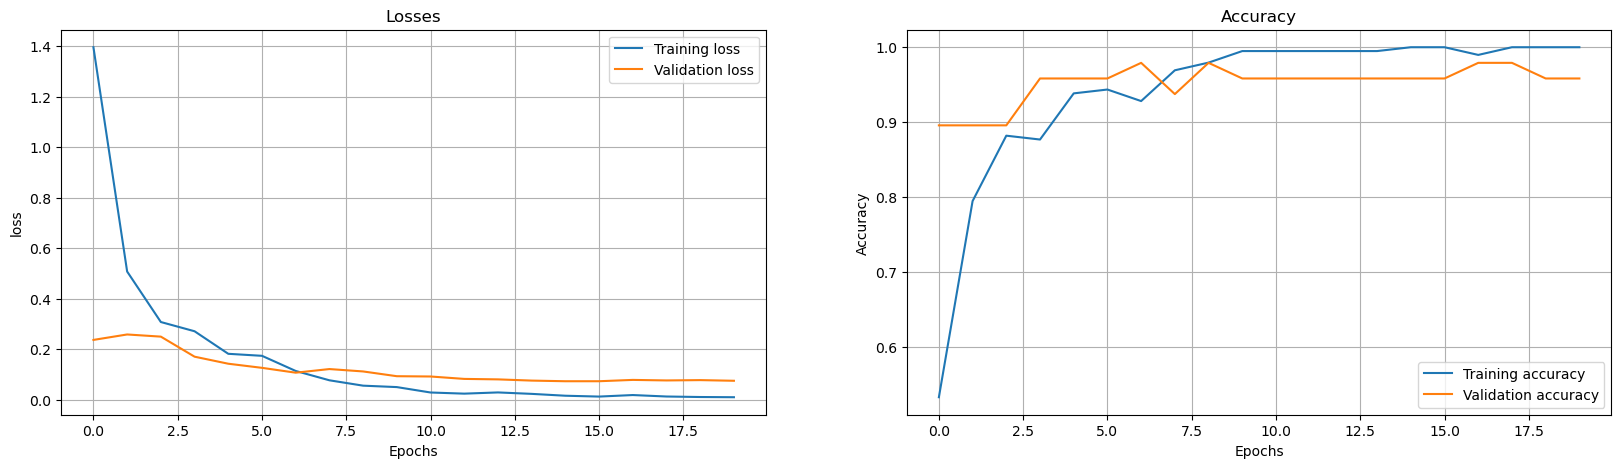

In [39]:
his_data = pd.DataFrame(history_combined.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [41]:
train_result = model_combined.evaluate(train_ds)
val_result = model_combined.evaluate(val_ds)
test_result = model_combined.evaluate(test_ds)

model1_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model1_result

1/1 [==============================] - 0s 331ms/step - loss: 1.9277 - accuracy: 0.5000


,Train,Validation,Testing
Loss,0.00968,0.073571,1.927738
Accuracy,1.00000,0.958333,0.500000


# **Further tune the model with augmented data**

We will use our augmented_data utility function to load augmented training data. Here we are using a callback function(reduce_lr) to decrease learning rate if the accuracy doesn't improve for 2 epochs.

In [ ]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                                                 patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model1.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
train_result = model1.evaluate(train_ds)
val_result = model1.evaluate(val_ds)
test_result = model1.evaluate(test_ds)

model1_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model1_result

In [ ]:
y_pred = model1.predict(test_ds[0][0])
y_pred = np.argmax(y_pred, axis=-1)

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# 2. VGG19

We will use VGG19 pre-trained model from keras. You can read more details about it from [here](https://keras.io/api/applications/vgg/). We will use the pre-trained model as base model and will build a final segement with a Flatten layer and a Dense layer. We will use sigmoid activation for our output layer. For VGG19, we will use image size of 224*224.

**Training without data augmentation**

In [42]:
from keras.applications.vgg19 import VGG19
tf.keras.backend.clear_session()

#initializing new height and width for images
height=244
width=244

train_ds, val_ds, test_ds = image_gen(height, width)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(height,width,3)
)

base_model.trainable = False

model2 = Sequential([
    base_model,
    #GlobalAveragePooling2D(),
    Flatten(),
    #Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

model2.summary()

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [43]:
model2.compile(loss="binary_crossentropy", 
               optimizer=Adam(0.01), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model2.fit(train_ds, 
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 6.1611 - accuracy: 0.5538
Epoch 1: accuracy improved from -inf to 0.55385, saving model to model/vgg19_best.h5
7/7 [==============================] - 8s 641ms/step - loss: 6.1611 - accuracy: 0.5538 - val_loss: 2.0752 - val_accuracy: 0.7708
Epoch 2/30
6/7 [========================>.....] - ETA: 0s - loss: 2.9191 - accuracy: 0.7500
Epoch 2: accuracy improved from 0.55385 to 0.75385, saving model to model/vgg19_best.h5
7/7 [==============================] - 1s 183ms/step - loss: 2.8742 - accuracy: 0.7538 - val_loss: 4.0051 - val_accuracy: 0.6875
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 1.9113 - accuracy: 0.7795
Epoch 3: accuracy improved from 0.75385 to 0.77949, saving model to model/vgg19_best.h5
7/7 [==============================] - 1s 209ms/step - loss: 1.9113 - accuracy: 0.7795 - val_loss: 3.8690 - val_accuracy: 0.7708
Epoch 4/30
6/7 [========================>.....] - ETA: 0s - loss: 1.0738 - a

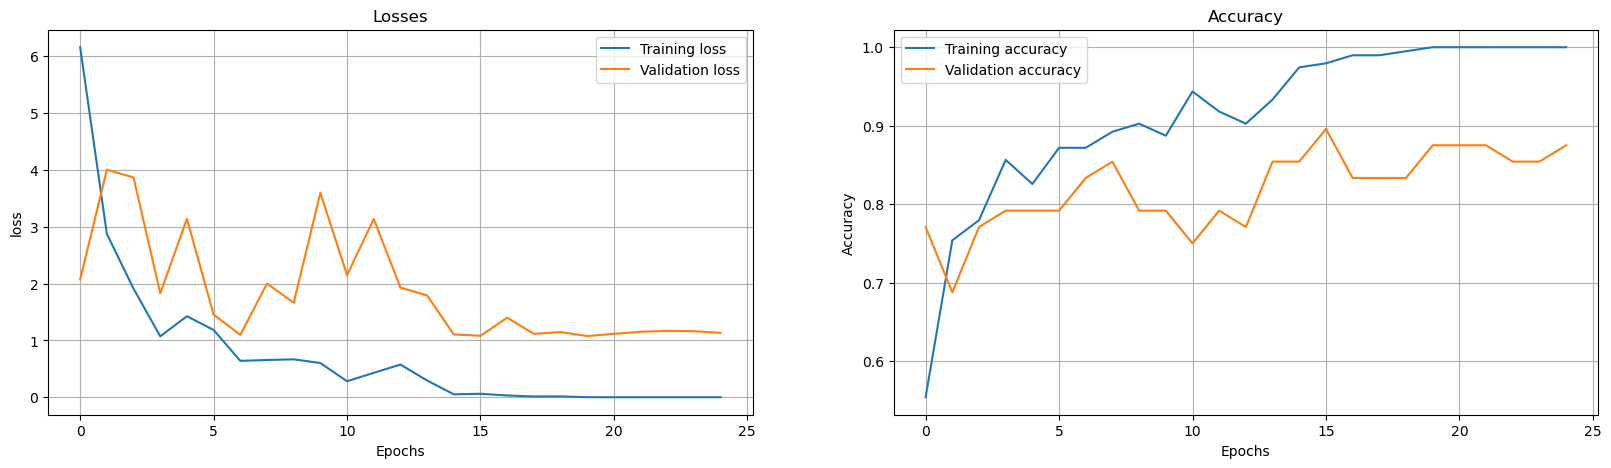

In [44]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

# ResNet + VGG

In [45]:
from keras.applications import ResNet50V2, VGG19
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Concatenate, Input
from keras.optimizers import Adam
import tensorflow as tf

# Clear Keras session
tf.keras.backend.clear_session()

# Load ResNet50V2 as the first base model
resnet_model = ResNet50V2(input_shape=(height, width, 3), include_top=False)
resnet_model.trainable = False

# Load VGG19 as the second base model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(height, width, 3))
vgg_model.trainable = False

# Define input layer
input_layer = Input(shape=(height, width, 3))

# Obtain outputs from both models
resnet_output = resnet_model(input_layer)
vgg_output = vgg_model(input_layer)

# Global average pooling and flattening for both outputs
resnet_output = GlobalAveragePooling2D()(resnet_output)
resnet_output = Flatten()(resnet_output)

vgg_output = GlobalAveragePooling2D()(vgg_output)
vgg_output = Flatten()(vgg_output)

# Concatenate the outputs
merged_output = Concatenate()([resnet_output, vgg_output])

# Dense layers
dense_layer = Dense(256, activation="relu", kernel_initializer='he_normal')(merged_output)
dropout_layer = Dropout(0.3)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Create the combined model
model_combined = Model(inputs=input_layer, outputs=output_layer)

# Compile the combined model
model_combined.compile(optimizer=Adam(),
                      loss="binary_crossentropy",
                      metrics=['accuracy'])

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/combined_resnet_vgg_best.h5',
                                                monitor='accuracy', verbose=1,
                                                mode='max', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint, early]

# Train the combined model
history_combined = model_combined.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)


Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 1.0031 - accuracy: 0.6000
Epoch 1: accuracy improved from -inf to 0.60000, saving model to model/combined_resnet_vgg_best.h5
7/7 [==============================] - 7s 566ms/step - loss: 1.0031 - accuracy: 0.6000 - val_loss: 0.4190 - val_accuracy: 0.8750
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8154
Epoch 2: accuracy improved from 0.60000 to 0.81538, saving model to model/combined_resnet_vgg_best.h5
7/7 [==============================] - 2s 337ms/step - loss: 0.4146 - accuracy: 0.8154 - val_loss: 0.3166 - val_accuracy: 0.9167
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8564
Epoch 3: accuracy improved from 0.81538 to 0.85641, saving model to model/combined_resnet_vgg_best.h5
7/7 [==============================] - 3s 391ms/step - loss: 0.3413 - accuracy: 0.8564 - val_loss: 0.2502 - val_accuracy: 0.9167
Epoch 4/30
7/7 [==================

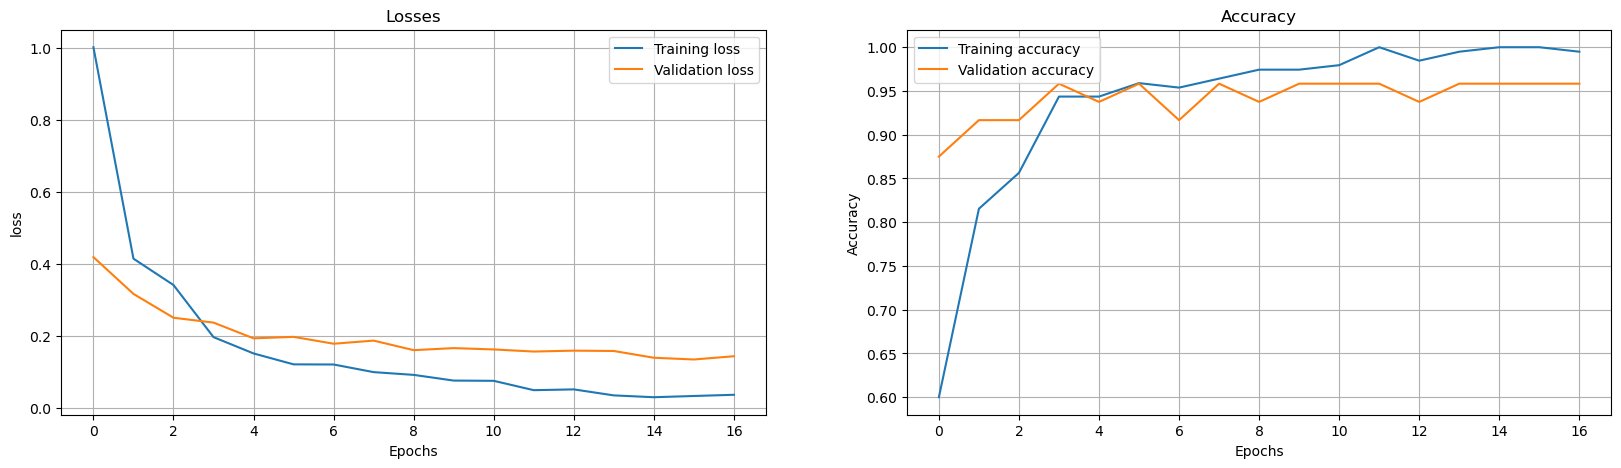

In [46]:
his_data = pd.DataFrame(history_combined.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [47]:
train_result = model_combined.evaluate(train_ds)
val_result = model_combined.evaluate(val_ds)
test_result = model_combined.evaluate(test_ds)

model1_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model1_result

1/1 [==============================] - 1s 1s/step - loss: 1.5263 - accuracy: 0.5000


,Train,Validation,Testing
Loss,0.034978,0.156153,1.526315
Accuracy,1.000000,0.958333,0.500000


# MobileNet + VGG

In [48]:
from keras.applications import MobileNetV2, VGG19
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Concatenate, Input
from keras.optimizers import Adam
import tensorflow as tf

# Clear Keras session
tf.keras.backend.clear_session()

# Load MobileNetV2 as the first base model
mobilenet_model = MobileNetV2(input_shape=(height, width, 3), include_top=False)
mobilenet_model.trainable = False

# Load VGG19 as the second base model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(height, width, 3))
vgg_model.trainable = False

# Define input layer
input_layer = Input(shape=(height, width, 3))

# Obtain outputs from both models
mobilenet_output = mobilenet_model(input_layer)
vgg_output = vgg_model(input_layer)

# Global average pooling and flattening for both outputs
mobilenet_output = GlobalAveragePooling2D()(mobilenet_output)
mobilenet_output = Flatten()(mobilenet_output)

vgg_output = GlobalAveragePooling2D()(vgg_output)
vgg_output = Flatten()(vgg_output)

# Concatenate the outputs
merged_output = Concatenate()([mobilenet_output, vgg_output])

# Dense layers
dense_layer = Dense(256, activation="relu", kernel_initializer='he_normal')(merged_output)
dropout_layer = Dropout(0.3)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Create the combined model
model_combined = Model(inputs=input_layer, outputs=output_layer)

# Compile the combined model
model_combined.compile(optimizer=Adam(),
                      loss="binary_crossentropy",
                      metrics=['accuracy'])

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/combined_mobilenet_vgg_best.h5',
                                                monitor='accuracy', verbose=1,
                                                mode='max', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint, early]

# Train the combined model
history_combined = model_combined.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)


Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.8189 - accuracy: 0.6051
Epoch 1: accuracy improved from -inf to 0.60513, saving model to model/combined_mobilenet_vgg_best.h5
7/7 [==============================] - 7s 492ms/step - loss: 0.8189 - accuracy: 0.6051 - val_loss: 0.7356 - val_accuracy: 0.4167
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.7487
Epoch 2: accuracy improved from 0.60513 to 0.74872, saving model to model/combined_mobilenet_vgg_best.h5
7/7 [==============================] - 2s 291ms/step - loss: 0.4868 - accuracy: 0.7487 - val_loss: 0.4797 - val_accuracy: 0.7083
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8308
Epoch 3: accuracy improved from 0.74872 to 0.83077, saving model to model/combined_mobilenet_vgg_best.h5
7/7 [==============================] - 2s 267ms/step - loss: 0.3583 - accuracy: 0.8308 - val_loss: 0.3064 - val_accuracy: 0.9167
Epoch 4/30
7/7 [=========

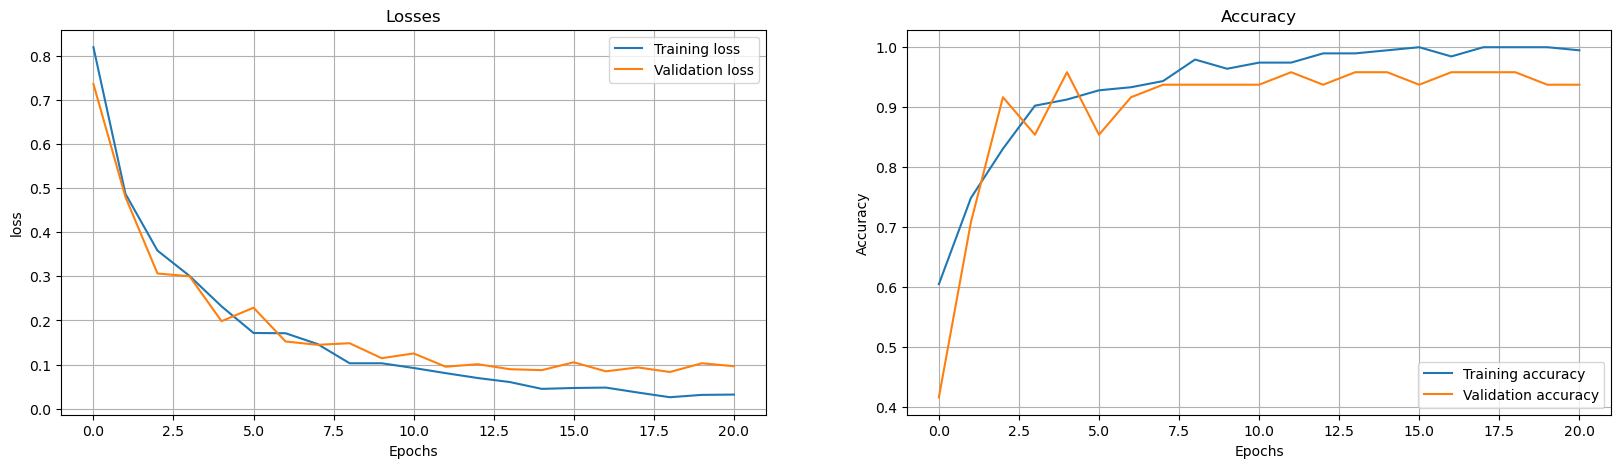

In [49]:
his_data = pd.DataFrame(history_combined.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [50]:
train_result = model_combined.evaluate(train_ds)
val_result = model_combined.evaluate(val_ds)
test_result = model_combined.evaluate(test_ds)

model1_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model1_result

1/1 [==============================] - 0s 186ms/step - loss: 1.2466 - accuracy: 0.5000


,Train,Validation,Testing
Loss,0.039045,0.105292,1.246627
Accuracy,1.000000,0.937500,0.500000


# ResNet + VGG + MobileNet

In [51]:
from keras.applications import ResNet50V2, VGG19, MobileNetV2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Concatenate, Input
from keras.optimizers import Adam
import tensorflow as tf

# Clear Keras session
tf.keras.backend.clear_session()

# Load pre-trained models
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False

mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_model.trainable = False

# Define input layer
input_layer = Input(shape=(224, 224, 3))

# Obtain outputs from each model
resnet_output = resnet_model(input_layer)
vgg_output = vgg_model(input_layer)
mobilenet_output = mobilenet_model(input_layer)

# Global average pooling and flattening for each output
resnet_output = GlobalAveragePooling2D()(resnet_output)
resnet_output = Flatten()(resnet_output)

vgg_output = GlobalAveragePooling2D()(vgg_output)
vgg_output = Flatten()(vgg_output)

mobilenet_output = GlobalAveragePooling2D()(mobilenet_output)
mobilenet_output = Flatten()(mobilenet_output)

# Concatenate the outputs
merged_output = Concatenate()([resnet_output, vgg_output, mobilenet_output])

# Dense layers
dense_layer = Dense(256, activation="relu", kernel_initializer='he_normal')(merged_output)
dropout_layer = Dropout(0.3)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Create the combined model
model_combined = Model(inputs=input_layer, outputs=output_layer)

# Compile the combined model
model_combined.compile(optimizer=Adam(),
                      loss="binary_crossentropy",
                      metrics=['accuracy'])

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/combined_resnet_vgg_mobilenet_best.h5',
                                                monitor='accuracy', verbose=1,
                                                mode='max', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint, early]

# Train the combined model
history_combined = model_combined.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)


Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 1.2473 - accuracy: 0.5590
Epoch 1: accuracy improved from -inf to 0.55897, saving model to model/combined_resnet_vgg_mobilenet_best.h5
7/7 [==============================] - 11s 789ms/step - loss: 1.2473 - accuracy: 0.5590 - val_loss: 0.8730 - val_accuracy: 0.6250
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.7949
Epoch 2: accuracy improved from 0.55897 to 0.79487, saving model to model/combined_resnet_vgg_mobilenet_best.h5
7/7 [==============================] - 3s 416ms/step - loss: 0.5085 - accuracy: 0.7949 - val_loss: 0.3625 - val_accuracy: 0.8542
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.8667
Epoch 3: accuracy improved from 0.79487 to 0.86667, saving model to model/combined_resnet_vgg_mobilenet_best.h5
7/7 [==============================] - 3s 413ms/step - loss: 0.2797 - accuracy: 0.8667 - val_loss: 0.1712 - val_accuracy: 0.9375
Epo

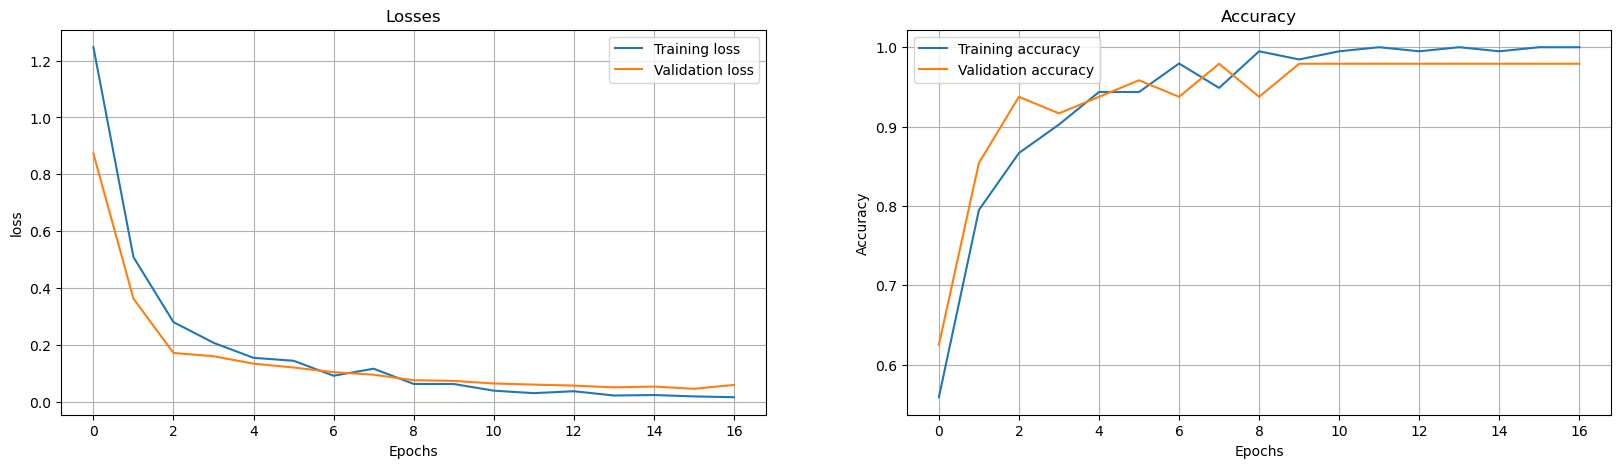

In [52]:
his_data = pd.DataFrame(history_combined.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [53]:
train_result = model_combined.evaluate(train_ds)
val_result = model_combined.evaluate(val_ds)
test_result = model_combined.evaluate(test_ds)

model1_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model1_result

1/1 [==============================] - 0s 158ms/step - loss: 1.4593 - accuracy: 0.5000


,Train,Validation,Testing
Loss,0.020405,0.059793,1.459277
Accuracy,1.000000,0.979167,0.500000


# Further tune the model with augmented data**

We will use our augmented_data utility function to load augmented training data. Here we are using a callback function(reduce_lr) to decrease learning rate if the accuracy doesn't improve for 2 epochs.

In [ ]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.3,patience=2, 
                                                 min_lr=0.0000001)
callbacks_list = [checkpoint,early, reduce_lr]

history = model2.fit(aug_train_ds, 
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
train_result = model2.evaluate(train_ds)
val_result = model2.evaluate(val_ds)
test_result = model2.evaluate(test_ds)

model2_result = pd.DataFrame(zip(train_result, val_result, test_result), 
                             columns=['Train', 'Validation', 'Testing'], 
                             index=['Loss', "Accuracy"])

model2_result

In [ ]:
y_pred = model2.predict(test_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# Conclusion

We have a great results on our all three models. With data augmentation, we have increased the validation accuracy(val_accuray) significatly also reduced over-fitting to the training dataset. Since we had a really small dataset, the models might overfit to the train and validation data which can be reduced by adding more data. Overall we have achieved a great results.

A little comparison between the three models:


                    train_Accuracy   val_accuracy   test_accuracy

1. ResNet50V2:
                        
                         100%            ~100%         ~60%
2. VGG19:

                         99%             ~97%          ~40%          
3. InceptionV3:

                        100%            ~100%          ~70%

Please upvote if you like this notebook. Thank you!

# Combine Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16, ResNet50

# Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Load the ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Define your custom classification layers
num_classes = 2  # Replace with the number of classes in your dataset

# VGG Model
vgg_output = vgg_model.output
vgg_output = keras.layers.GlobalAveragePooling2D()(vgg_output)
vgg_output = keras.layers.Dense(256, activation='relu')(vgg_output)
vgg_output = keras.layers.Dropout(0.6)(vgg_output)
vgg_output = keras.layers.Dense(num_classes, activation='softmax', name='vgg_predictions')(vgg_output)

# ResNet Model
resnet_output = resnet_model.output
resnet_output = keras.layers.GlobalAveragePooling2D()(resnet_output)
resnet_output = keras.layers.Dense(256, activation='relu')(resnet_output)
resnet_output = keras.layers.Dropout(0.6)(resnet_output)
resnet_output = keras.layers.Dense(num_classes, activation='softmax', name='resnet_predictions')(resnet_output)

# Create the combined model
combined_model = keras.Model(inputs=[vgg_model.input, resnet_model.input], outputs=[vgg_output, resnet_output])
X_vgg = tf.ones((100, 244, 244, 3))  # Replace with your VGG feature data
X_resnet = tf.ones((100, 244, 244, 3))  # Replace with your ResNet feature data

# Example labels (replace with your actual labels)
y_combined = tf.one_hot(tf.concat([tf.zeros(100, dtype=tf.int32)], axis=0), depth=2)  # Assuming 100 samples

# Create a custom layer to concatenate the features
concat_layer = keras.layers.Concatenate()([X_vgg, X_resnet])


In [ ]:

combined_model = keras.Model(inputs=[vgg_model.input, resnet_model.input], outputs=[vgg_output, resnet_output])

combined_model.compile(
    optimizer='adam',
    loss={'vgg_predictions': 'categorical_crossentropy', 'resnet_predictions': 'categorical_crossentropy'},
    metrics=['accuracy']
)

history = combined_model.fit([X_vgg, X_resnet], [y_combined, y_combined], batch_size=32, epochs=30,)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['vgg_predictions_loss'], label='VGG Training Loss')
plt.plot(history.history['resnet_predictions_loss'], label='ResNet Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss
if 'val_vgg_predictions_loss' in history.history and 'val_resnet_predictions_loss' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_vgg_predictions_loss'], label='VGG Validation Loss')
    plt.plot(history.history['val_resnet_predictions_loss'], label='ResNet Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot training accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['vgg_predictions_accuracy'], label='VGG Training Accuracy')
plt.plot(history.history['resnet_predictions_accuracy'], label='ResNet Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy
if 'val_vgg_predictions_accuracy' in history.history and 'val_resnet_predictions_accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_vgg_predictions_accuracy'], label='VGG Validation Accuracy')
    plt.plot(history.history['val_resnet_predictions_accuracy'], label='ResNet Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


# Applying ML Algorithm

# SVM

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data directory
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/'
# Define image data generators for training and testing
batch_size = 32
image_size = (244, 244)

# Create data generator for preprocessing and training
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale pixel values to the [0, 1] range
    rotation_range=15,  # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift the width of images
    height_shift_range=0.1,  # Randomly shift the height of images
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest',  # How to fill newly created pixels after rotations or shifts
    validation_split=0.2,
)

train_generator = train_data_gen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # You may need to adjust this depending on your data
    subset='training',
)

# Now, you can use train_generator in your model for training.
# Create a data generator for preprocessing the test set
test_data_gen = ImageDataGenerator(
    rescale=1.0 / 255  # Rescale pixel values to the [0, 1] range
)

test_generator = test_data_gen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # You may need to adjust this depending on your data
    subset='validation'  # Use the validation subset for testing
)

# Now, you can use test_generator to evaluate your model.

In [ ]:
#svm
import tensorflow as tf
from tensorflow import keras
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the data directory path
data_dir = "../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

# Load the dataset using image_dataset_from_directory
data = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",  # You may need to adjust this depending on your data
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="training",
    seed=1337  # Add a seed for reproducibility
)

# Create a data generator for the test set
test_data = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",  # You may need to adjust this depending on your data
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="validation",
    seed=1337  # Use the same seed for consistency
)

# Extract features and labels from the data and test_data
X_train, y_train = [], []
for images, labels in data:
    features = images.numpy().reshape(images.shape[0], -1)  # Flatten each image
    X_train.extend(features)
    y_train.extend(labels.numpy())
X_train, y_train = tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)

X_test, y_test = [], []
for images, labels in test_data:
    features = images.numpy().reshape(images.shape[0], -1)  # Flatten each image
    X_test.extend(features)
    y_test.extend(labels.numpy())
X_test, y_test = tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)

# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


# Random Forest

In [ ]:
#random forest algorithm 
from sklearn.ensemble import RandomForestClassifier
# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1337)  # You can adjust hyperparameters as needed
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")

# K-NN

In [ ]:
#K-NN algorithm
from sklearn.neighbors import KNeighborsClassifier

# Train a K-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_classifier.fit(X_train, y_train)

# Make predictions using the K-NN classifier
y_pred_knn = knn_classifier.predict(X_test)

# Calculate and print the accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"K-NN Accuracy: {accuracy_knn * 100:.2f}%")


# Naive Bayes

In [ ]:
#Naive bayes
from sklearn.naive_bayes import GaussianNB

# Train a Naive Bayes classifier
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, y_train)

# Make predictions using the Naive Bayes classifier
y_pred_naive_bayes = naive_bayes_classifier.predict(X_test)

# Calculate and print the accuracy
accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
print(f"Naive Bayes Accuracy: {accuracy_naive_bayes * 100:.2f}%")


# Decision Tree

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, y_train)

# Make predictions using the Decision Tree classifier
y_pred_decision_tree = decision_tree_classifier.predict(X_test)

# Calculate and print the accuracy
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print(f"Decision Tree Accuracy: {accuracy_decision_tree * 100:.2f}%")


# Logistic regression 

In [ ]:
#Logistic regression 
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()
logistic_regression_classifier.fit(X_train, y_train)

# Make predictions using the Logistic Regression classifier
y_pred_logistic_regression = logistic_regression_classifier.predict(X_test)

# Calculate and print the accuracy
accuracy_logistic_regression = accuracy_score(y_test, y_pred_logistic_regression)
print(f"Logistic Regression Accuracy: {accuracy_logistic_regression * 100:.2f}%")
